# Environment setup 


## Installing CLIP and YoloV5 and Imports

It the first section of this file, the installation of the needed components is performed. These first bash lines install CLIP and YoloV5 respectively. These two Neural Network will represent the ground base of the project development.

In [ ]:
%%capture
%%bash
# Download CLIP and YOLO
pip install git+https://github.com/openai/CLIP.git
pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

# Command to install some needed dependencies in the AWS machine
sudo apt-get update && sudo apt-get install ffmpeg libsm6 libxext6 -y

## List of imports

In [ ]:
# general imports
import pickle
import json
import tarfile
import os
import math
import torch
import clip
from PIL import Image, ImageDraw

# utility libraries imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

# torch imports
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torchvision import transforms

## Setting the Clip model and Yolo model variables

In [ ]:
# Chosing the device 
device = "cuda" if torch.cuda.is_available() else "cpu"

# choosing the clip model and the yolo versions, both pre-trained
clip_model, preprocess = clip.load('RN50', device)
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', force_reload=True, trust_repo=True) 

# Ensure the model is in float32 precision and transferred to the correct device
clip_model = clip_model.to(device).float()

# Fine-tuning Clip

## Dataset and Dataloaders

The following code sections contain the needed structures to load the data from the refcoco dataset.
The structures needed are:
1. a Dataset Class to load the Data
2. a Dataloader instantiation, to be used to split data into batches and that will be used to iterate throiugh for train, validation and test

The purpose of the Refcocog is Referring Expression Grounding, whose goal is to identify an object given a referring example. This is corresponds with the objective of this project.

The dataset is composed of 25799 images, each having an average of 3.7 referring expression. These expression are related to specific objects inside the image. The Ground truth is represented by the bounding boxes.

The set of file composing the dataset are:
 - instances.json which contains all the information about the bunding boxes of each image
   example of instance
 - ref(umd).p which is a serialized file with all the description related to a bounding box and the split it belongs to (train/validation/test)
 - the images directory with all the images

This Dataset class, reads the instances.json and refs(umd).p files, creates an association image_id->image_name and annotation_id -> bounding_boxes to simplify the retrivial of the single element in the getitem() method.\
Moreover, a set of samples is created with all the datase entries, each seample is composed of: image id, annotation id, and the sentence. The oobjective of this structure, besides contaioning all samples for the len() method, is to simplify the implementation of the getitem method.\
The latter takes as input an idx (which is the element currently being processed by the iterator) and return the image cropped to the bounding boxes and the sentence related with that box.

In [ ]:
class RefCOCOgDataset(Dataset):
    def __init__(self, transform=None, split='train', device='cuda', crop=False):
        # Load images and transform
        self.image_dir = os.path.join('refcocog', 'images')
        self.transform = transform

        # Define class properties for split and device
        self.split = split
        self.device = device
        self.crop = crop

        # Load data from ref(umd) and instances files
        self.refs = self.load_refs()
        self.instances = self.load_instances()

        # Create efficient lookup dictionaries
        self.image_id_to_filename = {img['id']: img['file_name'] 
                                   for img in self.instances['images']}
        self.ann_id_to_bbox = {ann['id']: ann['bbox'] 
                              for ann in self.instances['annotations']}

        # Prepare samples
        self.samples = self._prepare_samples()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # Load and process image
        image_name = self.image_id_to_filename[sample['image_id']]
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path)

        # Get and process bbox
        bbox = self.ann_id_to_bbox[sample['ann_id']]

        # Get and process bbox
        box = self.ann_id_to_bbox[sample['ann_id']]
        x1, y1, w, h = box
        x2, y2 = x1 + w, y1 + h

        # Optional: crop image to bounding boxes (for CLIP fine-tuning)
        if self.crop:
            # Ensure bbox coordinates are valid
            x1 = max(0, int(x1))
            y1 = max(0, int(y1))
            x2 = min(image.size[0], int(x2))
            y2 = min(image.size[1], int(y2))

            # Crop and transform
            image = image.crop((x1, y1, x2, y2))

        if self.transform:
            image = self.transform(image)

        # Sample to return
        sample = {
            'image_path':image,
            'preprocessed_image': image,
            'sentence': sample['sentence'],
            'bbox': torch.Tensor([x1,y1,x2,y2])
        }
        return sample

    def load_refs(self):
        annotation_file = os.path.join('refcocog', 'annotations', 'refs(umd).p')

        with open(annotation_file, 'rb') as f:
            data = pickle.load(f)
        return [item for item in data if item['split'] == self.split]

    def load_instances(self):
        instances_file = os.path.join('refcocog', 'annotations', 'instances.json')
        with open(instances_file, 'r') as f:
            return json.load(f)

    def _prepare_samples(self):
        samples = []
        for ref in self.refs:
            for sentence in ref['sentences']:
                samples.append({
                    'image_id': ref['image_id'],
                    'ann_id': ref['ann_id'],
                    'sentence': sentence['sent']
                })
        return samples

Three different dasets class are instantiated, one for the train set, one for the validation test, and one for the test set. 

Each class is then loaded in a DataLoader wrapper. All these dataloader have been designed to work leveraging multithreading, with the goal of speeding up training and validation.\
It is important to point out that while the train set is shuffled, the validation and test set are not, since it wouyld be pointless to shuffle them. \
Moreover, data are split in batches whose size is 64. This parameter has also been chosen for speed reason, and 64 elements batches represent a good trade-of, since batches are nor too large or too somal, and the update of the weights happens after a reasonable amount of examples (given the dataset size).

In [ ]:
# Train, test, and validation set split cropping images
finetune_train_dataset = RefCOCOgDataset(transform=preprocess, split='train', crop=True)
finetune_val_dataset = RefCOCOgDataset(transform=preprocess, split='val', crop=True)
finetune_test_dataset = RefCOCOgDataset(transform=preprocess, split='test', crop=True)

# DataLoaders batch size and other options. Computation is done with 4 workers to speed it up
batch_size = 64
shuffle = True
num_workers = 4
pin_memory = True
persistent_workers = True

# DataLoader, to create iterable batches with 32 examples each, shuffled in case of training set and not shuffled in case of validation set
finetune_train_loader = DataLoader(
    dataset=finetune_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)

finetune_val_loader = DataLoader(
    dataset=finetune_val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)

finetune_test_loader = DataLoader(
    dataset=finetune_test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)

print("=======================================================")
print("Number of training samples:",len(finetune_train_dataset))
print("Number of validation samples:",len(finetune_val_dataset))
print("Number of test samples:",len(finetune_test_loader))
print("=======================================================")


## 1. Default model

### Train and Validation functions

The optimizer chosen for the pretraining is Adam, with a low learning rate to perform a good fine tuning without overwriting weights coming from the pre-train.\
The fine-tuning model seems to be prone to overfitting, as different values of learning rate have been tested but yet the accuracy on the validation set after the 5th or 6th iteration started to grow. \
After trying different values for the learning rate (1e-4, 5e-5, and 1e-5), the best solution giving the best results over all epochs was: ADD CORRECT LEARNING RATE
some other hyperparameters have been set in the optimizer to enhance the training phase:
 - beta values to control the momentum of the update of the learning rate and the sability of the updates, which is set to 0.8 insetead of the default 0.999
 - eps,  YET TO UNDERSTAND IF IT MAKES SENSE TO USE IT
 - weight decay, to penalize large weights and preserve the information coming from the pre-train


In [ ]:
# Loss functions
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()


# Training function
def train_epoch(model, dataloader, optimizer, device, transform=None):
    model.train()
    total_loss = 0
    pbar = tqdm(dataloader, total=len(dataloader))

    for batch in pbar:
        images = batch["preprocessed_image"].to(device, non_blocking=True)
        texts = clip.tokenize(batch["sentence"]).to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        # Forward pass
        logits_per_image, logits_per_text = model(images, texts)

        # Compute loss
        ground_truth = torch.arange(len(images), dtype=torch.long, device=device)
        loss_image = loss_img(logits_per_image, ground_truth)
        loss_text = loss_txt(logits_per_text, ground_truth)
        loss = (loss_image + loss_text) / 2

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_description(f'Loss: {loss.item():.4f}')

    return total_loss / len(dataloader)

# Validation function
def validate(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    total_accuracy = 0

    pbar = tqdm(dataloader, total=len(dataloader), desc='Validation')

    with torch.no_grad():
        for batch in pbar:
            # Correctly extract images and texts from the batch
            images = batch["preprocessed_image"].to(device, non_blocking=True)
            texts = clip.tokenize(batch["sentence"]).to(device, non_blocking=True)
            # Forward pass
            logits_per_image, logits_per_text = model(images, texts)

            # Calculate loss
            ground_truth = torch.arange(len(images), dtype=torch.long, device=device)
            loss_image = loss_img(logits_per_image, ground_truth)
            loss_text = loss_txt(logits_per_text, ground_truth)
            loss = (loss_image + loss_text) / 2

            # Calculate accuracy
            predictions = torch.argmax(logits_per_image, dim=1)
            accuracy = (predictions == ground_truth).float().mean()

            total_loss += loss.item()
            total_accuracy += accuracy.item()

            # Update progress bar
            pbar.set_description(f'Val Loss: {loss.item():.4f} | Val Accuracy: {accuracy.item():.4f}')

    # Calculate average metrics
    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_accuracy / len(dataloader)

    return avg_loss, avg_accuracy

### Train and validation loop
Training loop that generates the pretrained clip model on refCocog.\
Given the size of the dataset and the depth of the clip model, the number of epochs is set to 10.\
Reminding that the notebook was executed in a ml.g4dn.xlarge aws machine (the most powerful allowed as reported in the course's slides), the train for each epoch took about 21 minutes. 

In [ ]:
# Learning rate and optimizer
lr=5e-7
# optimizer = Adam(clip_model.parameters(), lr=1e-3) # Overfit
# optimizer = Adam(clip_model.parameters(), lr=5e-5, betas=(0.9, 0.98), eps=1e-6, weight_decay=0.02) # Overfit
# optimizer = Adam(clip_model.parameters(), lr=5e-6, betas=(0.9, 0.98), weight_decay=0.02) # Overfit
# optimizer = Adam(clip_model.parameters(), lr=1e-6, betas=(0.9, 0.98), weight_decay=0.02) # Overfit
optimizer = Adam(clip_model.parameters(), lr=5e-7, betas=(0.9, 0.98), weight_decay=0.02) # Overfit

# Number of epochs for training
num_epochs = 10

# Store losses for plotting
training_losses = []
validation_losses = []
validation_accuracies = []

# Training loop
for epoch in range(1, num_epochs + 1):  # Start epochs from 1 for readability
    print(f"\nEpoch {epoch +1}/{num_epochs}")

    # Train and Validate for one epoch
    train_loss = train_epoch(clip_model, finetune_train_loader, optimizer, device)
    val_loss, val_accuracy = validate(clip_model, finetune_val_loader, device)

    # Store losses for plotting
    training_losses.append(train_loss)
    validation_losses.append(val_loss)
    validation_accuracies.append(val_accuracy)

    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")

# Save the final fine-tuned model
torch.save(clip_model.state_dict(), 'fine_tuned_clip_refcocog_final.pth')
print("\nTraining complete. Model saved as 'fine_tuned_clip_refcocog_final.pth'.")


### Results graphs

In [ ]:
%matplotlib inline
# Plot Training and Validation Losses
plt.figure(figsize=(12, 6))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss', marker='o', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), validation_accuracies, label='Validation Accuracy', marker='o', color='tab:blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)

# Display both plots
plt.tight_layout()
plt.show()

# Save the plots
plt.savefig('training_curves_finetuning1',lr,'.png')
plt.close()

Result with learning rate = lr = 5e-7:\
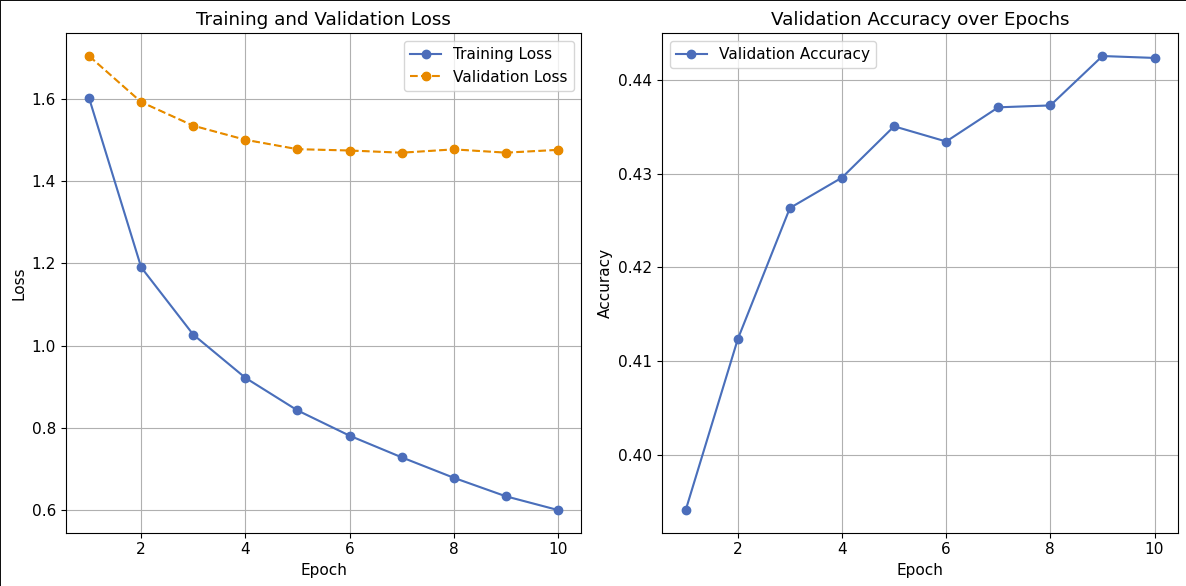

### Test

In [ ]:
test_loss, test_accuracy = validate(clip_model, finetune_test_loader, device)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

## 2. Custom CLIP model
After trying different parameters for the learning rate, from 5e-5 down to 5e-7, it is clear that to obtain a meaninful impact with the pretrain another approach has to be used.\
As the image above shows, very few improvements are done after the fourth epoch of finetuning, and the results on the validation test have not been very sarisfying as the validation accuracy increases but not consistenly and not significantly enough.\
For this reason I decided to add an attention layer at the end of CLIP. Hence the idea is to define a new model that does the image and text encoding, then apply a fully connected layer at the and, and again train the network, allowing the last layer to be fully trained by the clip images.\
This new model will be trainined leveragin the freezing layers technoque, where the last layers of the clip model will be freezed and no weight update will be applied and teh alst one and the first layers will be trained.\
The purpose of this is to let the network enhance its performances in the most general 

### Model

In [ ]:
class CLIPGrounding(nn.Module):
    def __init__(self, clip_model, hidden_dim=512):
        super().__init__()
        self.clip_model = clip_model
        self.clip_dim = self.clip_model.visual.output_dim

        # Projection layers
        self.visual_projection = nn.Sequential(
            nn.Linear(self.clip_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim)
        )

        self.text_projection = nn.Sequential(
            nn.Linear(self.clip_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, images, texts):
        # Encode images and text with CLIP
        with torch.no_grad():
            image_features = self.clip_model.encode_image(images)
            text_tokens = clip.tokenize(texts).to(images.device)
            text_features = self.clip_model.encode_text(text_tokens)

        # Ensure features are in the correct dtype
        image_features = image_features.to(self.visual_projection[0].weight.dtype)
        text_features = text_features.to(self.text_projection[0].weight.dtype)

        # Project features through our layers
        image_features = self.visual_projection(image_features)
        text_features = self.text_projection(text_features)

        # Normalize features (add epsilon to avoid NaN)
        image_features = F.normalize(image_features, dim=-1, eps=1e-6)
        text_features = F.normalize(text_features, dim=-1, eps=1e-6)

        return image_features, text_features


### Train and validation functions

In [ ]:
def train_epoch(model, train_loader, optimizer, device, epoch):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}')
    for batch in pbar:
        # print("batch: ",batch)
        images = batch['preprocessed_image'].to(device)
        texts = batch['sentence']

        # print("images: ",images)
        # print("texts: ",texts)

        # Forward pass
        image_features, text_features = model(images, texts)
        # print("image_features: ",image_features)
        # print("text_features: ",text_features)

        # Calculate similarity matrix
        similarity = image_features @ text_features.t()
        # print("similarity: ",similarity)

        # Labels for contrastive learning (diagonal is positive pairs)
        labels = torch.arange(len(images)).to(device)

        # Calculate loss (both image->text and text->image directions)
        loss_i2t = F.cross_entropy(similarity, labels)
        loss_t2i = F.cross_entropy(similarity.t(), labels)
        # print("loss_i2t: ",loss_i2t)
        # print("loss_t2i: ",loss_t2i)

        loss = (loss_i2t + loss_t2i) / 2
        # print("loss: ",loss)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Calculate accuracy
        predictions = similarity.argmax(dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_samples += len(images)

        # Update progress bar
        total_loss += loss.item()
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct_predictions / total_samples:.2f}%'
        })

    return total_loss / len(train_loader), correct_predictions / total_samples

def validate(model, val_loader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validating'):
            images = batch['preprocessed_image'].to(device)
            texts = batch['sentence']

            image_features, text_features = model(images, texts)
            similarity = image_features @ text_features.t()

            labels = torch.arange(len(images)).to(device)
            loss_i2t = F.cross_entropy(similarity, labels)
            loss_t2i = F.cross_entropy(similarity.t(), labels)
            loss = (loss_i2t + loss_t2i) / 2

            predictions = similarity.argmax(dim=1)
            correct_predictions += (predictions == labels).sum().item()
            total_samples += len(images)
            total_loss += loss.item()

    return total_loss / len(val_loader), correct_predictions / total_samples

### Train and validation loop

In [ ]:
# Create model
ft_clip_model = CLIPGrounding(clip_model).to(device)

# Learning rates
# lr=5e-5
lr = 1e-4

# Initialize optimizer with weight decay
optimizer = torch.optim.AdamW(
    ft_clip_model.parameters(),
    lr = lr,
    weight_decay=0.01,
    eps=1e-8
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=num_epochs
)

num_epochs = 10

# Lists to store metrics
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

best_val_acc = 0

# Train/validation loop
for epoch in range(num_epochs):
    # Train epoch
    train_loss, train_acc = train_epoch(
        ft_clip_model, finetune_train_loader, optimizer, device, epoch
    )

    # Validate
    val_loss, val_acc = validate(ft_clip_model, finetune_val_loader, device)

    # Store metrics
    training_losses.append(train_loss)
    validation_losses.append(val_loss)
    training_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    # Update learning rate
    scheduler.step()

    # Print metrics
    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%')

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'ft_clip_model_state_dict': ft_clip_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, 'best_refcocog_ft_clip_model.pth')

### Results graphs

In [ ]:
%matplotlib inline
# Plot training curves
plt.figure(figsize=(15, 5))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss', marker='o', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot Accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), training_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), validation_accuracies, label='Validation Accuracy', marker='o', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout and display plots
plt.tight_layout()
plt.show()

# Save the plots
image_name = f'training_curves_finetuning2_{lr}.png'
plt.savefig(image_name)
plt.close()

### Test

# Models 

## Dataset and Dataloaders

In [ ]:
#SECOND VERSION WITHOUT OPENING IMAGES
class RefCOCOgDatasetModel(Dataset):
    def __init__(self, transform=None, split='train', device='cuda', crop=False):
        # Load images and transform
        self.image_dir = os.path.join('refcocog', 'images')
        self.transform = transform

        # Define class properties for split and device
        self.split = split
        self.device = device
        self.crop = crop

        # Load data from ref(umd) and instances files
        self.refs = self.load_refs()
        self.instances = self.load_instances()

        # Create efficient lookup dictionaries
        self.image_id_to_filename = {img['id']: img['file_name'] 
                                   for img in self.instances['images']}
        self.ann_id_to_bbox = {ann['id']: ann['bbox'] 
                              for ann in self.instances['annotations']}

        # Prepare samples
        self.samples = self._prepare_samples()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # Load and process image
        image_name = self.image_id_to_filename[sample['image_id']]
        image_path = os.path.join(self.image_dir, image_name)

        # Get and process bbox
        bbox = self.ann_id_to_bbox[sample['ann_id']]

        # Get and process bbox
        box = self.ann_id_to_bbox[sample['ann_id']]
        x1, y1, w, h = box
        x2, y2 = x1 + w, y1 + h

        # Optional: crop image to bounding boxes (for CLIP fine-tuning)
        if self.crop:
            # Ensure bbox coordinates are valid
            x1 = max(0, int(x1))
            y1 = max(0, int(y1))
            x2 = min(image.size[0], int(x2))
            y2 = min(image.size[1], int(y2))


        # Sample to return
        sample = {
            'image_path':str(image_path),
            'sentence': sample['sentence'],
            'bbox': torch.Tensor([x1,y1,x2,y2])
        }
        return sample

    def load_refs(self):
        annotation_file = os.path.join('refcocog', 'annotations', 'refs(umd).p')

        with open(annotation_file, 'rb') as f:
            data = pickle.load(f)
        return [item for item in data if item['split'] == self.split]

    def load_instances(self):
        instances_file = os.path.join('refcocog', 'annotations', 'instances.json')
        with open(instances_file, 'r') as f:
            return json.load(f)

    def _prepare_samples(self):
        samples = []
        for ref in self.refs:
            for sentence in ref['sentences']:
                samples.append({
                    'image_id': ref['image_id'],
                    'ann_id': ref['ann_id'],
                    'sentence': sentence['sent']
                })
        return samples

# Define a function to open images
def open_images(image_paths, preprocess):
    # Ensure image_paths is a list
    if isinstance(image_paths, str):
        image_paths = [image_paths]

    # Open and optionally preprocess all images
    opened_images = [preprocess(Image.open(path)) if preprocess else Image.open(path) for path in image_paths]

    # Return a single image if only one path was provided
    return opened_images[0] if len(opened_images) == 1 else opened_images

Since the goal of this model is to predict bounding boxes of an object in a picture from a textual description, new Dataset classes are created that do notapply any  crop or transformation to the images

In [ ]:
# Train, test, and validation set split cropping images, without applying any transformation 
train_dataset = RefCOCOgDatasetModel(transform=preprocess,split='train')
val_dataset = RefCOCOgDatasetModel(transform=preprocess,split='val')
test_dataset = RefCOCOgDatasetModel(transform=preprocess,split='test')

# DataLoaders batch size and other options. Computation is done with 4 workers to speed it up
batch_size = 64
shuffle = True
pin_memory = True
num_workers = 4
persistent_workers = True

# DataLoader, to create iterable batches with 32 examples each, shuffled in case of training set and not shuffled in case of test and validation sets
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)

print("=======================================================")
print("Number of training samples:",len(train_dataset))
print("Number of validation samples:",len(val_dataset))
print("Number of test samples:",len(test_dataset))
print("=======================================================")

## Loss function
https://learnopencv.com/yolo-loss-function-siou-focal-loss/ \
A class has been defined to implement SIoU loss function that will be used to train the models.\
Moreover, a function calculating MIoU and AP@50 and AP@75 have been implemented. These will be used just tas test metrics and to have a commond groud to be able to confront\
the base model and the custom model.

In [ ]:
def calculate_iou(boxes1, boxes2):

    # Calculate intersection coordinates
    x1 = torch.max(boxes1[:, 0], boxes2[:, 0])
    y1 = torch.max(boxes1[:, 1], boxes2[:, 1])
    x2 = torch.min(boxes1[:, 2], boxes2[:, 2])
    y2 = torch.min(boxes1[:, 3], boxes2[:, 3])

    # Calculate intersection area
    intersection = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)

    # Calculate union area
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])
    union = area1 + area2 - intersection

    # Calculate IoU
    iou = intersection / (union + 1e-6)  # Add small epsilon to avoid division by zero
    return iou


def calculate_siou(pred_boxes, target_boxes):

    '''
        Part 1: Calculating classical IoU
    '''
    # Get box coordinates
    pred_x1, pred_y1, pred_x2, pred_y2 = pred_boxes.chunk(4, dim=-1)
    target_x1, target_y1, target_x2, target_y2 = target_boxes.chunk(4, dim=-1)

    # Calculate box centers
    pred_cx = (pred_x1 + pred_x2) / 2
    pred_cy = (pred_y1 + pred_y2) / 2
    target_cx = (target_x1 + target_x2) / 2
    target_cy = (target_y1 + target_y2) / 2

    # Box widths and heights
    pred_w = pred_x2 - pred_x1
    pred_h = pred_y2 - pred_y1
    target_w = target_x2 - target_x1
    target_h = target_y2 - target_y1

    # Calculate intersection
    x1 = torch.max(pred_x1, target_x1)
    y1 = torch.max(pred_y1, target_y1)
    x2 = torch.min(pred_x2, target_x2)
    y2 = torch.min(pred_y2, target_y2)

    # Calculate areas
    intersection = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)
    pred_area = pred_w * pred_h
    target_area = target_w * target_h
    union = pred_area + target_area - intersection + 1e-7

    # IoU
    iou = intersection / union

    '''
        Part 2: Calculating angle, distance, and shape costs 
    '''
    # Distance component
    c_2 = torch.pow(target_cx - pred_cx, 2) + torch.pow(target_cy - pred_cy, 2)
    c = torch.sqrt(c_2 + 1e-7)

    # Diagonal length of the enclosing box
    d = torch.sqrt(torch.pow(torch.max(pred_x2, target_x2) - torch.min(pred_x1, target_x1), 2) +
                  torch.pow(torch.max(pred_y2, target_y2) - torch.min(pred_y1, target_y1), 2))

    # Distance ratio
    rho = c / (d + 1e-7)

    # Angle component
    pred_angle = torch.atan2(pred_cy - target_cy, pred_cx - target_cx)
    target_angle = torch.atan2(target_h, target_w)
    v = (4 / (math.pi ** 2)) * torch.pow(torch.atan2(target_w, target_h) - 
                                        torch.atan2(pred_w, pred_h), 2)

    # Calculate alpha (trade-off parameter for angle cost)
    alpha = v / (1 - iou + v + 1e-7)

    # Angle cost
    omega = v / (v + 1e-7)

    '''
        Part 2: Return final SIoU
    '''
    siou = 1 - iou + (rho + alpha * omega)

    return siou.squeeze()

class SIoULoss(nn.Module):
    def __init__(self, reduction='mean'):
        super().__init__()
        self.reduction = reduction

    def forward(self, pred_boxes, target_boxes, similarity_scores=None):

        siou_loss = calculate_siou(pred_boxes, target_boxes)

        # Add similarity score component if provided
        if similarity_scores is not None:
            # Convert similarity scores to a loss (1 - similarity)
            similarity_loss = 1 - similarity_scores
            # Combine losses (you can adjust the weighting)
            combined_loss = siou_loss + 0.5 * similarity_loss
        else:
            combined_loss = siou_loss

        if self.reduction == 'mean':
            return combined_loss.mean()
        elif self.reduction == 'sum':
            return combined_loss.sum()
        else: 
            return combined_loss

def calculate_test_metrics(pred_boxes, target_boxes, confidence_scores, iou_thresholds=[0.5, 0.75]):
    # Calculate IoU for all predictions
    ious = calculate_iou(pred_boxes, target_boxes)

    # Calculate MIoU
    miou = ious.mean().item()

    # Calculate AP for each threshold
    ap_dict = {}
    for thresh in iou_thresholds:
        # Sort by confidence scores
        sorted_indices = torch.argsort(confidence_scores, descending=True)
        sorted_ious = ious[sorted_indices]

        # Calculate precision and recall
        positives = (sorted_ious >= thresh).float()
        true_positives = torch.cumsum(positives, dim=0)
        total_positives = torch.sum(positives)

        if total_positives == 0:
            ap_dict[f'ap_{int(thresh*100)}'] = 0.0
            continue

        precision = true_positives / torch.arange(1, len(true_positives) + 1, device=true_positives.device)
        recall = true_positives / total_positives

        # Calculate AP using 11-point interpolation
        ap = 0.0
        for t in torch.linspace(0, 1, 11):
            if torch.sum(recall >= t) == 0:
                continue
            ap += torch.max(precision[recall >= t])
        ap = ap / 11.0
        ap_dict[f'ap_{int(thresh*100)}'] = ap.item()

    return {'miou': miou, **ap_dict}

## 1. Base Model

### Model definition

The base model is defined as a starting point to further study the task and become familiar with this visual grounding task.\
The approach is described in the project statement and is useful to get familiar with the visual grounding task. \
The idea is to feed the image inside YOLO to get the bounding boxes of all objects, apply to each the preprocessing and the find using clip the one that is the most close to the tokenizewd textual description. \
to find the object the closest to the description, the cosine similarity measure is used.

In [ ]:
class BaseModel(nn.Module):
    def __init__(self, yolo_model, clip_model, confidence_threshold=0.4, transform=None, device="cuda"):
        super().__init__()
        # Initialize class' variables
        self.device = device
        self.confidence_threshold = confidence_threshold
        self.transform = transform

        # Initialize class' models
        self.yolo_model = yolo_model
        self.clip_model = clip_model
        self.yolo_model.conf = confidence_threshold
        self.yolo_model.to(device)
        self.clip_model.to(device)

    def forward(self, images_paths, descriptions):

        # Lists to store results for the batch
        batch_best_boxes = []
        batch_best_scores = []
        images_producing_no_bbox = {
            "paths": [],
            "count": 0
        }
        # Process each image in the batch
        for idx in range(len(images_paths)):
            image_path = images_paths[idx]
            description = descriptions[idx]

            # Get all objects with YOLO inference
            with torch.no_grad():

                # Get yolo objects
                yolo_results = self.yolo_model(image_path)
                crops = yolo_results.crop(save=False)

                # Extract bounding boxes
                boxes = [torch.tensor(crop['box'], device=self.device) for crop in crops]

                # Prepare crops for CLIP
                crops = process_crops_for_clip(crops, transform=self.transform, device=self.device)


            # Convert list to batch tensor
            if crops is not None and len(crops) > 0:
                # Encode text description
                with torch.no_grad():
                    description_tokens = clip.tokenize(description).to(self.device)
                    description_embedding = self.clip_model.encode_text(description_tokens).float()
                    # Encode all object images at once
                    object_embeddings = self.clip_model.encode_image(crops).float()

                # Calculate similarities for all objects at once
                similarities = torch.cosine_similarity(
                    object_embeddings,
                    description_embedding.repeat(len(object_embeddings), 1),
                    dim=1
                )

                # Find best match
                best_match_index = similarities.argmax()
                best_match_box = boxes[best_match_index]  
                best_match_score = similarities[best_match_index]
            else:
                # Handle case where transform failed for all objects
                best_match_box = torch.zeros(4, device=self.device)
                best_match_score = torch.tensor(0.0, device=self.device)
                images_producing_no_bbox["paths"].append(image_path)
                images_producing_no_bbox["count"] += 1

            batch_best_boxes.append(best_match_box)
            batch_best_scores.append(best_match_score)

        # Stack results into tensors
        pred_boxes = torch.stack(batch_best_boxes)
        similarity_scores = torch.stack(batch_best_scores)

        return pred_boxes, similarity_scores,images_producing_no_bbox


def process_crops_for_clip(crops, transform=None, device='cuda'):
    if transform is None:
        transform = transforms.Compose([
            transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                               (0.26862954, 0.26130258, 0.27577711))
        ])

    processed_crops = []
    for crop in crops:
        # Extract image from crop dictionary
        if isinstance(crop, dict) and 'im' in crop:
            crop_img = crop['im']  # Get the actual image from the dictionary
        else:
            crop_img = crop

        # Convert numpy array to PIL Image if necessary
        if isinstance(crop_img, np.ndarray):
            crop_img = Image.fromarray(crop_img)

        # Process the image with the provided transform
        processed_crop = transform(crop_img).to(device)
        processed_crops.append(processed_crop)

    # Stack all processed crops into a batch
    if processed_crops:
        return torch.stack(processed_crops)
    return None

### Train/Validation/Test functions

The loss function used to train the model is the IoU (Intersection over Union), 

In [ ]:
def validate(model,
            val_loader,
            criterion,
            device):

    model.eval()
    total_loss = 0
    total_iou = 0
    total_samples = 0
    total_no_bbox_images = 0

    pbar = tqdm(val_loader, desc="Validating")
    for batch in pbar:
        # Get batch data
        images = batch['image_path']
        sentences = batch["sentence"]
        target_boxes = batch['bbox'].to(device, non_blocking=True)

        # Forward pass
        pred_boxes, similarity_scores, no_bbox_images = model(images, sentences)

        # Calculate loss
        loss = criterion(pred_boxes, target_boxes, similarity_scores)

        # Calculate metrics
        batch_size = len(images)
        total_samples += batch_size
        total_loss += loss.item() * batch_size
        total_no_bbox_images += no_bbox_images["count"]

        # Update progress bar
        pbar.set_postfix({
            'loss': f'{total_loss/total_samples:.4f}',
            'total_no_bbox_images': f'{total_no_bbox_images}'
        })

    return {
        'loss': total_loss / total_samples,
        'total_no_bbox_images': total_no_bbox_images
    }


def test(model, val_loader, criterion, device):

    model.eval()
    total_loss = 0
    total_samples = 0
    total_no_bbox_images = 0

    # Lists to store all predictions and targets for metric calculation
    all_pred_boxes = []
    all_target_boxes = []
    all_confidence_scores = []

    # For accuracy/precision calculation
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    pbar = tqdm(val_loader, desc="Validating")
    for batch in pbar:
        # Get batch data
        images = batch['image_path']
        sentences = batch["sentence"]
        target_boxes = batch['bbox'].to(device, non_blocking=True)
        # Forward pass
        pred_boxes, similarity_scores, no_bbox_images = model(images, sentences)
        # Calculate loss
        loss = criterion(pred_boxes, target_boxes, similarity_scores)

        # Calculate IoU between predictions and targets
        ious = calculate_iou(pred_boxes, target_boxes)

        # Consider a prediction correct if IoU > 0.5
        correct_predictions = (ious > 0.5)

        # Update metrics
        true_positives += torch.sum(correct_predictions).item()
        false_positives += torch.sum(~correct_predictions).item()

        # Fix for false negatives calculation
        total_targets = target_boxes.size(0)  # Number of target boxes
        false_negatives += total_targets - torch.sum(correct_predictions).item()

        # Store predictions and targets for metric calculation
        all_pred_boxes.append(pred_boxes)
        all_target_boxes.append(target_boxes)
        all_confidence_scores.append(similarity_scores)

        # Update totals
        batch_size = len(images)
        total_samples += batch_size
        total_loss += loss.item() * batch_size
        total_no_bbox_images += no_bbox_images["count"]

        # Update progress bar
        pbar.set_postfix({
            'loss': f'{total_loss/total_samples:.4f}',
            'total_no_bbox_images': f'{total_no_bbox_images}'
        })

    # Calculate accuracy and precision
    total_predictions = true_positives + false_positives + false_negatives
    accuracy = true_positives / total_predictions if total_predictions > 0 else 0
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0

    # Concatenate all predictions and targets
    all_pred_boxes = torch.cat(all_pred_boxes)
    all_target_boxes = torch.cat(all_target_boxes)
    all_confidence_scores = torch.cat(all_confidence_scores)

    # Calculate other metrics
    metrics = calculate_test_metrics(
        all_pred_boxes,
        all_target_boxes,
        all_confidence_scores,
        iou_thresholds=[0.5, 0.75]
    )

    return {
        'loss': total_loss / total_samples,
        'accuracy': accuracy,
        'precision': precision,
        'miou': metrics['miou'],
        'ap_50': metrics['ap_50'],
        'ap_75': metrics['ap_75'],
        'total_no_bbox_images': total_no_bbox_images
    }

def print_metrics(name, metrics):
    line_length = 50
    print("\n" + "=" * line_length)
    print(f"{name} Metrics".center(line_length))
    print("=" * line_length)
    for key, value in metrics.items():
        # Format percentage metrics
        if key in ['miou', 'ap_50', 'ap_75', 'accuracy', 'precision']:
            formatted_value = f"{value*100:.1f}%"
        elif isinstance(value, float):
            formatted_value = f"{value:.4f}"
        else:
            formatted_value = str(value)

        # Pretty print each metric
        key_display = key.replace('_', ' ').upper()
        print(f"{key_display:<20} : {formatted_value:>10}")
    print("-" * line_length)

Instantiating and evaluating the model

In [ ]:
# Initialize model, criterion, optimizer
base_model = BaseModel(yolo_model, clip_model)
criterion = SIoULoss()

# Test the model on the validation and test set 
val_metrics = validate(base_model, val_loader, criterion, device)
test_metrics = test(base_model, test_loader, criterion, device)

# Print both metrics
print_metrics("Validation", val_metrics)
print_metrics("Test", test_metrics)

## 2.  Custom Model

### Model definition

The idea of the custom model is rather simple, and somehow it resempbles what has been done for the pre-train.\
The modeltakes the fine-tuned CLIP anc concatenates layers to predict the bounding boxes. The idea is that the output of the encoded text and image are fed into the last layers to obtain the bounding boxes. 

In [ ]:
class CustomModel1(nn.Module):

    def __init__(self, clip_grounding_model, hidden_dim=512):
        super().__init__()

        # Set the pretrained clip model
        self.clip_grounding_model = clip_grounding_model

        # concatenate a MLP for bounding boxes
        self.bbox_head = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 4)
        )

    def forward(self, images, texts):

        # Extract global image and text features
        with torch.no_grad():
            image_features, text_features = self.clip_grounding_model(images, texts)

        # Normalize features
        image_features = F.normalize(image_features, dim=-1, eps=1e-6)
        text_features = F.normalize(text_features, dim=-1, eps=1e-6)

        # Concatenate image and text features
        combined_features = torch.cat([image_features, text_features], dim=-1)

        # Predict bounding boxes
        bounding_boxes = self.bbox_head(combined_features) 

        return bounding_boxes

### Train/Validation/Test functions

The loss function used to train the model is the IoU (Intersection over Union), 

# Notes on what to do 

Things to consider when implementing the custom model are:
 - Data augmentation (increase the size of the dataset by applying transformations to the images)
 - Regularization techniques
 - Hyperparameters tuning (partially done in the fine-tuning part, as different values of learning rate have been tested)

Evaluation is done on measures like:
 - localization accuracy
 - grounding accuracy
 - semantic similarity

In [ ]:
# yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', force_reload=True, trust_repo=True) 

base_transform = transforms.Compose([
            transforms.ToTensor(),  # Convert PIL to tensor and normalize to [0,1]
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])  # ImageNet normalization
        ])


#Images returning an empty crop
# refcocog/images/COCO_train2014_000000276874.jpg
# refcocog/images/COCO_train2014_000000276874.jpg
# refcocog/images/COCO_train2014_000000497807.jpg
# refcocog/images/COCO_train2014_000000497807.jpg


yolo_model.conf = 0.2

im1 = 'refcocog/images/COCO_train2014_000000380440.jpg'
im2 = 'refcocog/images/COCO_train2014_000000560180.jpg'


# Load the images
image1 = Image.open(im1)
image2 = Image.open(im2)

# image1 = base_transform(image1)
# image2 = base_transform(image2)

# image1 = image1.resize((640, 640))
# image2 = image2.resize((640, 640))

print(f"Shape of Image 1: {image1.size}")  # (width, height)
print(f"Shape of Image 2: {image2.size}")

# Show the images
# image1.show(title="Image 1")
# image2.show(title="Image 2")

#Process first image
results = yolo_model(im1)  # inference
print("results image 1")
# print("result1")
# print(results) 
results.show()

#Process second image
results = yolo_model(im2)  # inference
print("results image 2")
# print("result2")
# print(results)
results.show()
